-----
Established on Week 8, Semester 1, 2025

# 1D Model of Inverse Problem - Apportion Sources in River Networks

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import copy

## Forward model: 1D Advection-Dispersion Equation (ADE)

For pollution in groudwater and surface water, the pollutant concentration can be written as: 

$$ R\frac{\partial \alpha \varepsilon C}{\partial t} = -\nabla(\alpha \varepsilon C U) + \nabla (\alpha \varepsilon D \nabla C) - \alpha \varepsilon k C + \alpha \varepsilon \varphi$$

If we only focus on surface water, $R$ should be 1 and we can devide $\alpha \varepsilon$ and obtain: 

$$ \frac{\partial C}{\partial t} = -U\frac{\partial C}{\partial x} + D \frac{\partial^2 C}{\partial x^2} - k C + S(x, t)$$

where $x$ represents the position (spatial) and $t$ represents the time (temporal). Thus, concentration $C(x, t)$ is a distribution of spatiotemporal information of pollutant, and $S(x, t)$ is source which includes spatiotemporal information as well. 

The model can be more complex. For general situation, the dispersion coefficient tensor $D$ can be related to position and time as river flows forward, and the decay coefficient $k$ can be affected by temperature, which results in a general equation with multiple sources as followed: 

$$ \frac{\partial C}{\partial t} = -U\frac{\partial C}{\partial x} + D(x, t) \frac{\partial^2 C}{\partial x^2} - k(T) C + \sum_{k}S_k(x, t)$$

Moreover, for source term, it can be instant where source release mass $M$ pollutant at $x_k$ and $t_0$. And it also can be steady/time-varing, releasing pollutant as a certain/time-dependent rate in $[t_1, t_2]$. 

However, as a start-up, I develop 1D model here by using analytical solutions (or numerical solutions based on finite differences, here I use an approximation based on spatiotemporal discretisation for simplicity). 

For a one-dimensional 'water body', I assume velocity $U$ and dispersion coefficient $D$ are constants (they should not be, but I assume they are in this case). 

The analytical solution of the source (instant/pulse) at $x=0, t=0$ releases mass $M$ is：
$$C(x, t; x_0, M) = \frac{M}{\sqrt{4 \pi D t}} \exp \left[ - \frac{(x - x_0 - U t)^2}{4 D t} \right] \cdot \exp(-k t)$$
where I introduce a decay term $\exp(-kt)$. 

With the boundary conditions: 
$$ S(x_0, t_0=0) = M $$

In [ ]:
# --- initialise hydrological parameters ---
U = 0.5  # velocity (m/s)
D = 0.8  # dispersion coefficient (m^2/s)
k = 0.05 # 0 (1/s)

def forward_model(t, x, p, velocity=U, dispersion=D, decay=k):
    """
    Analytical Solution to 1D Advention-Dispersion-Reaction Equation (instant source)

    Parameters:
    t (float): time
    x (float): position
    p (list/array): source parameters [M, x0] (mass, original release location)
    Return:
    C (float): pollutant concentration
    """
    M, x0 = p[0], p[1]

    # Avoid the singularity when t=0
    if t < 0.1:
        return 0.0

    # Analytical solution formula
    term1 = M / np.sqrt(4 * np.pi * dispersion * t)
    term2_exp = - (x - x0 - velocity * t)**2 / (4 * dispersion * t)
    decay_exp = -decay * t

    C = term1 * np.exp(term2_exp) * np.exp(decay_exp)
    return C

## Construct Observation (Sparsity Simulation)

In [3]:
## Initialisation - define a "real source" to generate simulated observation data
# --- True source parameters ---
TRUE_MASS = 100.0
TRUE_POSITION = 50.0 # (m)
TRUE_PARAMS = np.array([TRUE_MASS, TRUE_POSITION])

# --- Set up observed data (sparse) ---
OBS_POINTS = np.array([80, 150, 220]) # three downstream stations (m)
OBS_TIMES = np.array([100, 200, 300]) # three observed time (s)

# Generate real observed data (add random noises to simulate the measured errors)
np.random.seed(42)
C_obs = np.zeros((len(OBS_POINTS), len(OBS_TIMES)))

print("--- Observation simulation (sparse C_obs) ---")
for i, x_i in enumerate(OBS_POINTS):
    for j, t_j in enumerate(OBS_TIMES):
        true_C = forward_model(t_j, x_i, TRUE_PARAMS)
        # add 5% Gaussian noise
        C_obs[i, j] = true_C + np.random.normal(0, 0.05 * true_C)
        print(f"Position={x_i}m, Time={t_j}s: C_obs={C_obs[i, j]:.4f}")

--- Observation simulation (sparse C_obs) ---
Position=80m, Time=100s: C_obs=0.0062
Position=80m, Time=200s: C_obs=0.0000
Position=80m, Time=300s: C_obs=0.0000
Position=150m, Time=100s: C_obs=0.0000
Position=150m, Time=200s: C_obs=0.0001
Position=150m, Time=300s: C_obs=0.0000
Position=220m, Time=100s: C_obs=0.0000
Position=220m, Time=200s: C_obs=0.0000
Position=220m, Time=300s: C_obs=0.0000


## Inverse Problem: Objective and Optimisation

Objective Function: Minimise the square error between calculated concentration and observed concentration (MSE). 

$$\mathcal{J}(\mathbf{p}) = \sum_{i} \sum_{j} \left[ C\_{\text{calc}}(x\_i, t\_j; \mathbf{p}) - C\_{\text{obs}}(x\_i, t\_j) \right]^2
$$

In [4]:
def objective_function(p, obs_points, obs_times, C_obs_flat, U=U, D=D, K=k, loss_history=None):
    """
    p (array): source parameters [M, x0]
    """
    C_calc_flat = np.zeros_like(C_obs_flat)
    k_idx = 0

    for i, x_i in enumerate(obs_points):
        for j, t_j in enumerate(obs_times):
            # calculate the concentration by using forward model and current p
            C_calc = forward_model(t_j, x_i, p, U, D, K)
            C_calc_flat[k_idx] = C_calc
            k_idx += 1

    J = np.sum((C_calc_flat - C_obs_flat)**2)

    if loss_history is not None:
        loss_history.append(J)
    return J

In [5]:
# Initialise a random set of parameters (different from the real one) 
INITIAL_MASS = 50.0
INITIAL_POSITION = 10.0
initial_guess = np.array([INITIAL_MASS, INITIAL_POSITION])

print("--- Inverse Solution ---")
# Use Nelder-Mead or L-BFGS-B (needs boundary constrains)
# For simple non-linear problem, Nelder-Mead is usually steady
result = minimize(objective_function, initial_guess, args=(OBS_POINTS, OBS_TIMES, C_obs.flatten()), 
method='Nelder-Mead', options={'disp': True, 'maxiter': 1000})

# Inferred results
INFERRED_MASS, INFERRED_POSITION = result.x
INFERRED_MASS = max(0, INFERRED_MASS)

--- Inverse Solution ---
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 505
         Function evaluations: 935


--- The results of inverse models ---
Real release mass M: 100.00
Inferred release mass M': 99.22
Real release position x0: 50.00 m
Inferred release postion x0': 49.74 m
Error of Obj: 2.0827e-12


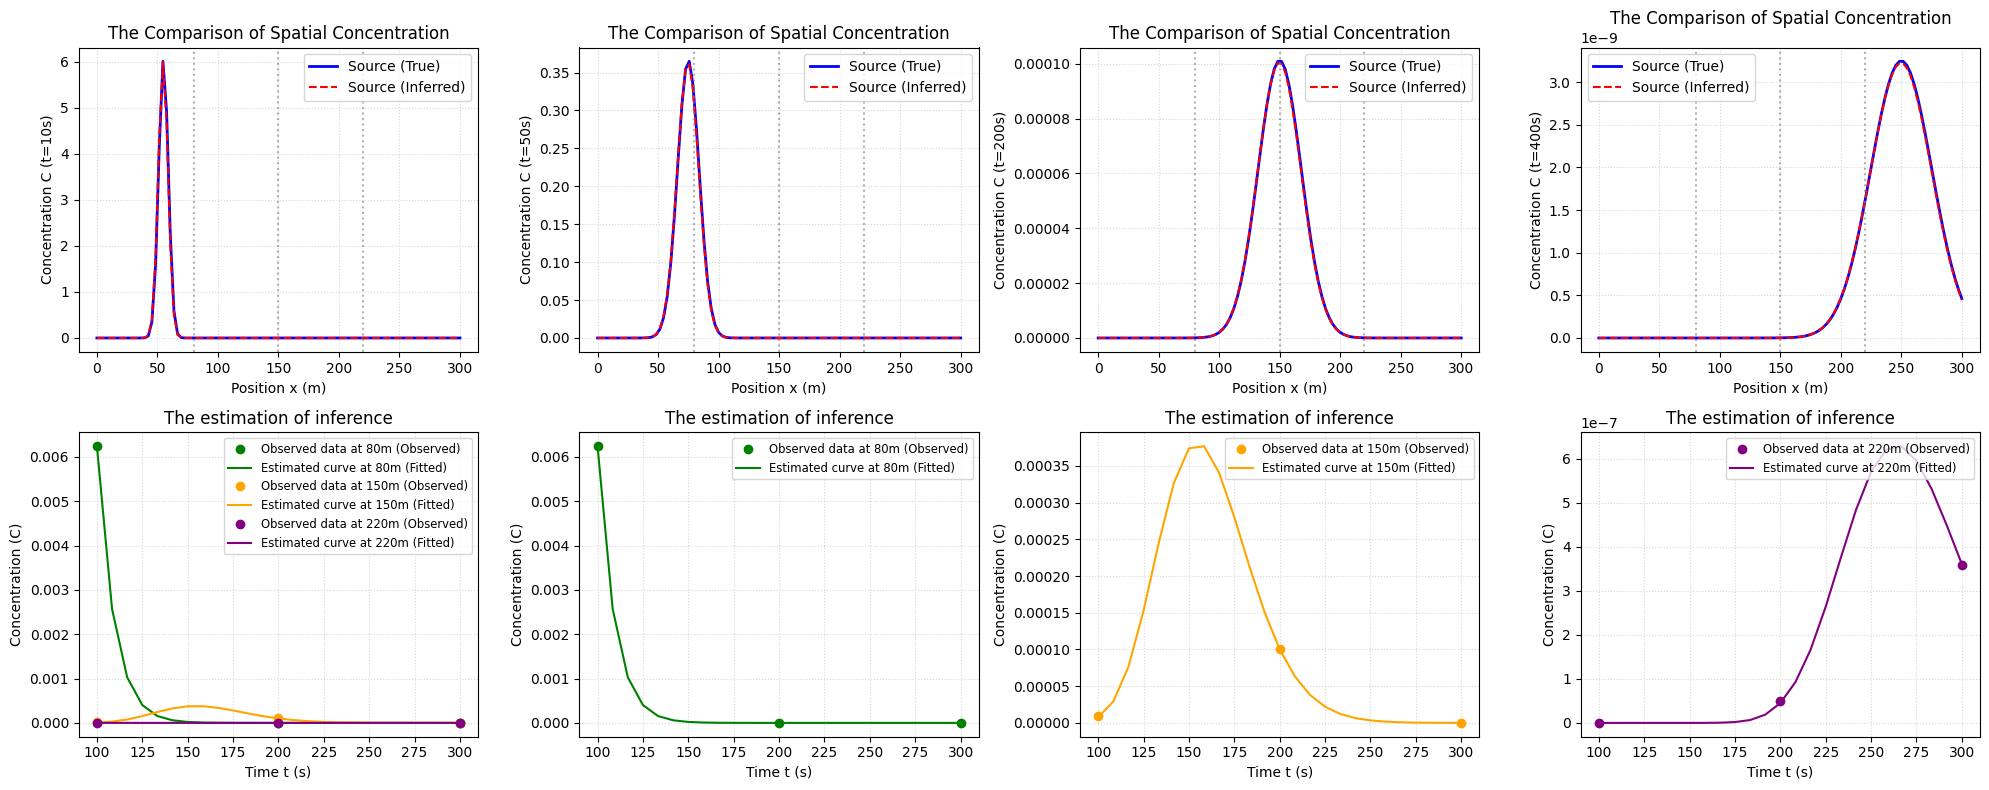

In [6]:
print("--- The results of inverse models ---")
print(f"Real release mass M: {TRUE_MASS:.2f}")
print(f"Inferred release mass M': {INFERRED_MASS:.2f}")
print(f"Real release position x0: {TRUE_POSITION:.2f} m")
print(f"Inferred release postion x0': {INFERRED_POSITION:.2f} m")
print(f"Error of Obj: {result.fun:.4e}")

INFERRED_PARAMS = np.array([INFERRED_MASS, INFERRED_POSITION])
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
# Compare concentration in space at a certain t
def compare_c_at_t(ax, T):
    T_PLOT = T
    X_PLOT = np.linspace(0, 300, 100)

    C_true_t = [forward_model(T_PLOT, x, TRUE_PARAMS) for x in X_PLOT]
    ax.plot(X_PLOT, C_true_t, label=f'Source (True)', color='blue', linewidth=2)
    C_inferred_t = [forward_model(T_PLOT, x, INFERRED_PARAMS) for x in X_PLOT]
    ax.plot(X_PLOT, C_inferred_t, label=f'Source (Inferred)', color='red', linestyle='--')

    for x_obs in OBS_POINTS:
        ax.axvline(x=x_obs, linestyle=':', color='gray', alpha=0.6)

    ax.set_xlabel('Position x (m)')
    ax.set_ylabel(f'Concentration C (t={T_PLOT}s)')
    ax.set_title('The Comparison of Spatial Concentration')
    ax.legend()
    ax.grid(True, linestyle='dotted', alpha=0.5)

compare_c_at_t(axes[0, 0], 10)
compare_c_at_t(axes[0, 1], 50)
compare_c_at_t(axes[0, 2], 200)
compare_c_at_t(axes[0, 3], 400)



# Model for inferring the observation 
ax2 = axes[1, 0]
colors = ['green', 'orange', 'purple']

for i, x_i in enumerate(OBS_POINTS):
    color = colors[i % len(colors)]
    # Observation
    C_obs_time_series = C_obs[i, :]
    ax2.plot(OBS_TIMES, C_obs_time_series, 
             marker='o', linestyle='', color=color, 
             label=f'Observed data at {x_i}m (Observed)')
    # Estimation
    T_FIT = np.linspace(min(OBS_TIMES), max(OBS_TIMES), 25)
    C_inferred_fit = [forward_model(t, x_i, INFERRED_PARAMS) for t in T_FIT]
    ax2.plot(T_FIT, C_inferred_fit, color=color, linestyle='-', 
             label=f'Estimated curve at {x_i}m (Fitted)')

ax2.set_xlabel('Time t (s)')
ax2.set_ylabel('Concentration (C)')
ax2.set_title('The estimation of inference')
ax2.legend(loc='upper right', fontsize='small')
ax2.grid(True, linestyle='dotted', alpha=0.5)


colors = ['green', 'orange', 'purple']
for i, x_i in enumerate(OBS_POINTS):
    ax2 = axes[1, i+1]
    color = colors[i % len(colors)]
    # Observation
    C_obs_time_series = C_obs[i, :]
    ax2.plot(OBS_TIMES, C_obs_time_series, 
            marker='o', linestyle='', color=color, 
            label=f'Observed data at {x_i}m (Observed)')
    # Estimation
    T_FIT = np.linspace(min(OBS_TIMES), max(OBS_TIMES), 25)
    C_inferred_fit = [forward_model(t, x_i, INFERRED_PARAMS) for t in T_FIT]
    ax2.plot(T_FIT, C_inferred_fit, color=color, linestyle='-', 
            label=f'Estimated curve at {x_i}m (Fitted)')

    ax2.set_xlabel('Time t (s)')
    ax2.set_ylabel('Concentration (C)')
    ax2.set_title('The estimation of inference')
    ax2.legend(loc='upper right', fontsize='small')
    ax2.grid(True, linestyle='dotted', alpha=0.5)

plt.tight_layout()
plt.show()

## Future Improvement

Based on the model and corresponding equations, I summarise 5 directions that I can attempt to improve in the next following weeks: 

1) For velocity term $U$, it can be related to position and time as $U(x,t)$. If the sensors in river don't calculate the real-time velocity, then we need to calculate it by flow and geometry features. 
2) For dispersion term $D$, it can also be dependent to position and time as $D(x,t)$. How to model this parameter is a point. 
3) For decay term $k$ of bacteria, it is probably determined by temperature, which should be $k(T)$ and uv and season as $k(T, uv)$. 
4) For source term $S(x,t)$, there can be multiple sources, resulting in $\sum_{k}S_k(x,t)$. How to seperate multiple sources in inverse problem is a challenge. 
5) For source term $\sum_{k}S_k(x,t)$, sources can be different types - discrete (pulse/instant) and continous (steady/time-varying). And if source releases continously, it can be released steadily at a certain rate $R$. Or it can be time-varying, like using a function to describe tha rate as $R(t)$. However, the continous release can be limited to an instant release if we consider a short enough interval $dt$. 

-------
Updated on Week 9, Semester 1, 2025

## Sensitivity Analysis: Physical Parameter Bias

This part is for parameters and the corresponding changes in model and its results. 

Here I defined several parameters for later analysis: 
1) U - velocity (m/s)
2) D - dispersion coefficient (m^2/s)
3) k - decay coefficient (1/s)

In [10]:
def paramater_test(U_test=None, D_test=None, K_test=None):
    '''
    U_test, D_test, K_test: List
    '''

    INITIAL_GUESS = np.array([50.0, 10.0])
    MAX_ITER = 1000

    all_loss_histories = {}
    final_inferred_params = {}

    if all([U_test, D_test, K_test]) is None:
        print("Enter a parameter among U, D, and K...")

    if U_test:
        for para_inferred in U_test:
            current_loss_history = [] 
            initial_p = copy.copy(INITIAL_GUESS)

            print(f"Optimizing U_inferred={para_inferred:.2f} ...")
            
            result = minimize(
                objective_function, 
                initial_p, 
                args=(OBS_POINTS, OBS_TIMES, C_obs.flatten(), 
                    para_inferred, D, k,
                    current_loss_history), 
                method='Nelder-Mead',
                options={'maxiter': MAX_ITER, 'disp': False}
            )

            all_loss_histories[para_inferred] = current_loss_history
            final_inferred_params[para_inferred] = result.x
            
            print(f"  Infer M*: {result.x[0]:.2f}, x0*: {result.x[1]:.2f}, Loss: {result.fun:.2e}")

    if D_test:
        for para_inferred in D_test:
            current_loss_history = [] 
            initial_p = copy.copy(INITIAL_GUESS)

            print(f"Optimizing D_inferred={para_inferred:.2f} ...")
            
            result = minimize(
                objective_function, 
                initial_p, 
                args=(OBS_POINTS, OBS_TIMES, C_obs.flatten(), 
                    U, para_inferred, k,
                    current_loss_history), 
                method='Nelder-Mead',
                options={'maxiter': MAX_ITER, 'disp': False}
            )

            all_loss_histories[para_inferred] = current_loss_history
            final_inferred_params[para_inferred] = result.x
            
            print(f"  Infer M*: {result.x[0]:.2f}, x0*: {result.x[1]:.2f}, Loss: {result.fun:.2e}")

    if K_test:
        for para_inferred in K_test:
            current_loss_history = [] 
            initial_p = copy.copy(INITIAL_GUESS)

            print(f"Optimizing K_inferred={para_inferred:.2f} ...")
            
            result = minimize(
                objective_function, 
                initial_p, 
                args=(OBS_POINTS, OBS_TIMES, C_obs.flatten(), 
                    U, D, para_inferred,
                    current_loss_history), 
                method='Nelder-Mead',
                options={'maxiter': MAX_ITER, 'disp': False}
            )

            all_loss_histories[para_inferred] = current_loss_history
            final_inferred_params[para_inferred] = result.x
            
            print(f"  Infer M*: {result.x[0]:.2f}, x0*: {result.x[1]:.2f}, Loss: {result.fun:.2e}")
    
    return all_loss_histories, final_inferred_params

In [11]:
# set up a list of parameters
U_TEST_LIST = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] # True: 0.5
D_TEST_LIST = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6] # True: 0.8
K_TEST_LIST = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10] # True: 0.05

U_loss, U_results = paramater_test(U_test=U_TEST_LIST)
D_loss, D_results = paramater_test(D_test=D_TEST_LIST)
K_loss, K_results = paramater_test(K_test=K_TEST_LIST)

Optimizing U_inferred=0.10 ...
  Infer M*: 154.83, x0*: 93.07, Loss: 8.04e-09
Optimizing U_inferred=0.20 ...
  Infer M*: 165.13, x0*: 83.51, Loss: 3.03e-09
Optimizing U_inferred=0.30 ...
  Infer M*: 142.28, x0*: 72.47, Loss: 4.04e-10
Optimizing U_inferred=0.40 ...
  Infer M*: 112.08, x0*: 60.70, Loss: 8.52e-12
Optimizing U_inferred=0.50 ...
  Infer M*: 99.22, x0*: 49.74, Loss: 2.08e-12
Optimizing U_inferred=0.60 ...
  Infer M*: 116.11, x0*: 40.97, Loss: 2.55e-11
Optimizing U_inferred=0.70 ...
  Infer M*: 138.72, x0*: 32.29, Loss: 1.49e-09
Optimizing U_inferred=0.80 ...
  Infer M*: 119.10, x0*: 21.17, Loss: 5.58e-09
Optimizing U_inferred=0.90 ...
  Infer M*: 98.84, x0*: -29.71, Loss: 8.56e-11
Optimizing U_inferred=1.00 ...
  Infer M*: 112.93, x0*: -40.76, Loss: 8.58e-11
Optimizing D_inferred=0.20 ...
  Infer M*: 38.29, x0*: 38.76, Loss: 4.31e-09
Optimizing D_inferred=0.40 ...
  Infer M*: 76.88, x0*: 44.47, Loss: 8.57e-11
Optimizing D_inferred=0.60 ...
  Infer M*: 87.07, x0*: 47.19, Loss

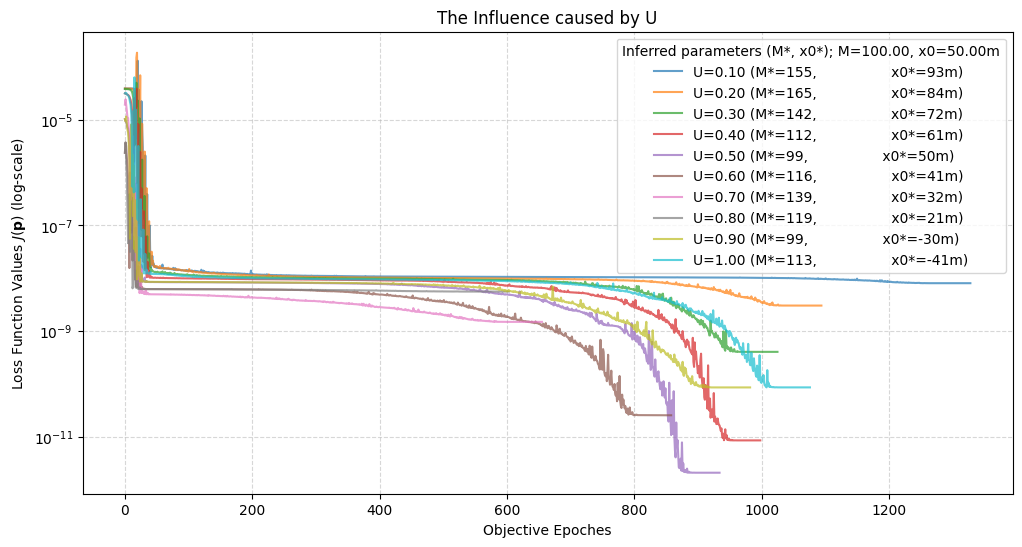

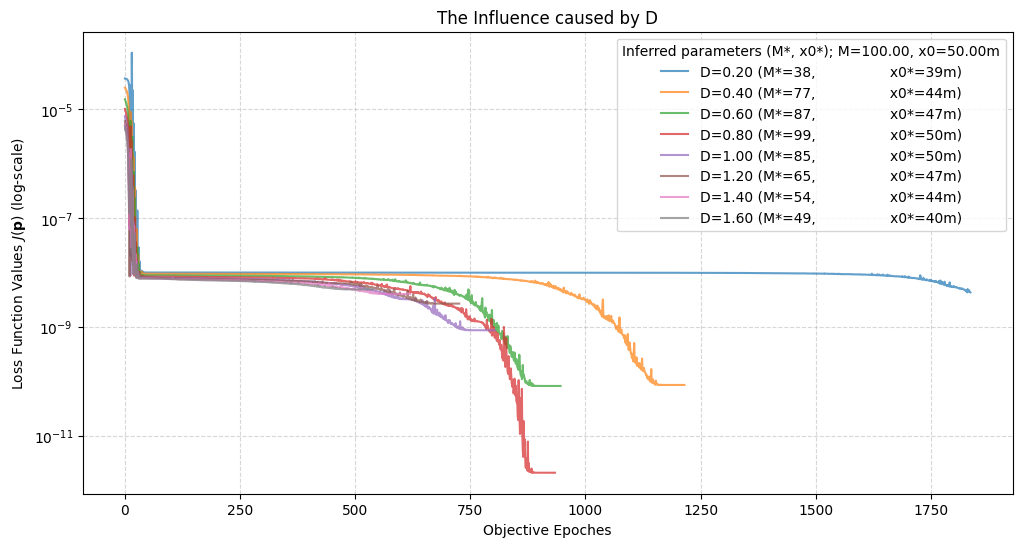

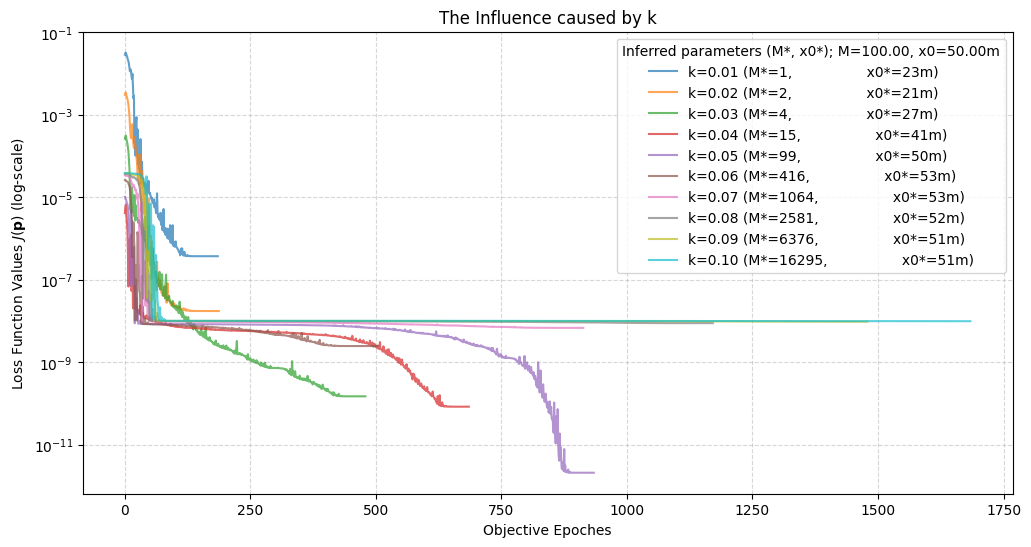

In [15]:
def plot_epoch_loss(all_loss_histories, final_inferred_params, para_name):

    plt.figure(figsize=(12, 6))

    for _inferred, history in all_loss_histories.items():
        iterations = np.arange(len(history))
        
        plt.plot(iterations, history, 
                label=f'{para_name}={_inferred:.2f} (M*={final_inferred_params[_inferred][0]:.0f}, \
                x0*={final_inferred_params[_inferred][1]:.0f}m)',
                alpha=0.7)

    plt.yscale('log') 
    plt.xlabel('Objective Epoches')
    plt.ylabel('Loss Function Values $J(\mathbf{p})$ (log-scale)')
    plt.title(f'The Influence caused by {para_name}')
    plt.legend(title=f"Inferred parameters (M*, x0*); M={TRUE_MASS:.2f}, x0={TRUE_POSITION:.2f}m", 
            loc='upper right')
    plt.grid(True, which="both", ls="--", alpha=0.5)

    plt.show()

    # print(f"Ture params: M={TRUE_MASS:.2f}, x0={TRUE_POSITION:.2f}m")
    # for U, p in final_inferred_params.items():
    #     print(f"U={U:.2f} | M*={p[0]:.2f}, x0*={p[1]:.2f}m, Loss={all_loss_histories[U][-1]:.2e}")

plot_epoch_loss(U_loss, U_results, 'U')
plot_epoch_loss(D_loss, D_results, 'D')
plot_epoch_loss(K_loss, K_results, 'k')

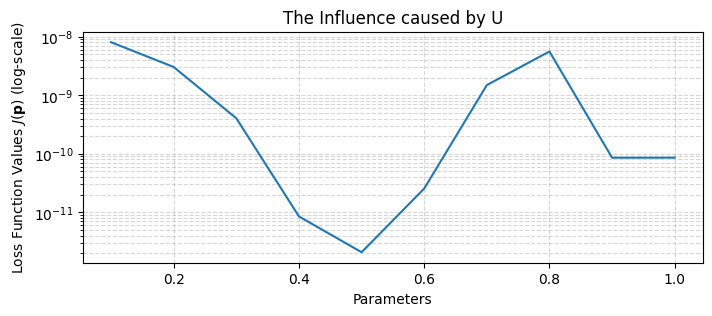

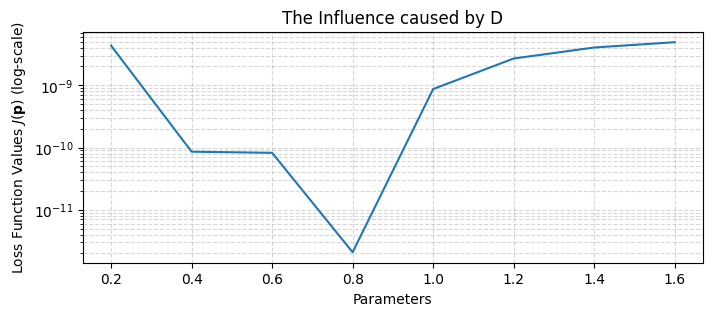

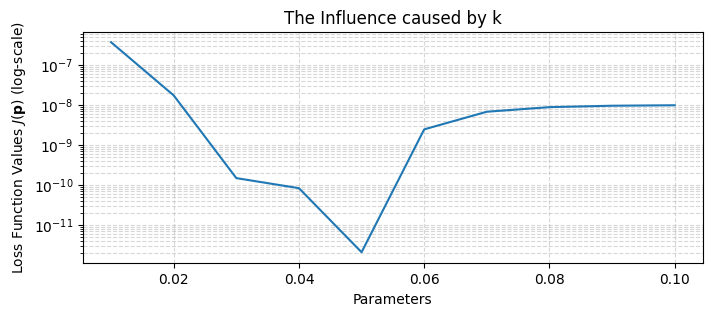

In [19]:
def plot_param_loss(all_loss_histories, para_name):

    plt.figure(figsize=(8, 3))

    final_loss = []

    for _inferred, history in all_loss_histories.items():
        final_loss.append([_inferred, history[-1]])
    final_loss = np.asarray(final_loss)

    plt.plot(final_loss[:,0], final_loss[:,1])

    plt.yscale('log')
    plt.xlabel('Parameters')
    plt.ylabel('Loss Function Values $J(\mathbf{p})$ (log-scale)')
    plt.title(f'The Influence caused by {para_name}')
    plt.grid(True, which="both", ls="--", alpha=0.5)

    plt.show()

plot_param_loss(U_loss, 'U')
plot_param_loss(D_loss, 'D')
plot_param_loss(K_loss, 'k')

----
Updated on Week 10, Semester 1, 2025

This week's work is loss function with different regularization. 

In this part, we are thinking about how to adapt regularization to the ill-posed inverse problem. Try to test different $\lambda$ term. 

Here are three distinct loss functions, all based on the Mean Squared Error (MSE) but using different regularization terms ($\mathcal{R}(\mathbf{p})$) to promote stability and sparsity.

1. Loss Function 1: Tikhonov Regularization (L2 Norm)

This is the most common form of regularization. It is ideal for promoting stability and preventing the source parameters from taking on unrealistically large values.

$$
\mathcal{J}_1(\mathbf{p}) = \mathcal{J}_{\text{data}}(\mathbf{p}) + \alpha_1 \cdot \mathcal{R}_{\text{Tikhonov}}(\mathbf{p})
$$

We apply the L2 norm, typically to the source masses/strengths ($M_i$) to keep them small.

$$
\mathcal{R}_{\text{Tikhonov}}(\mathbf{p}) = \sum_{i=1}^{N_s} M_i^2
$$

* $N_s$: Total number of potential sources we are trying to infer.
* $\alpha_1$: The Tikhonov parameter, a hyperparameter that controls the trade-off between fitting the data ($\mathcal{J}_{\text{data}}$) and keeping the source masses small.

2. Loss Function 2: LASSO Regularization (L1 Norm)

This regularization is essential for problems where we suspect that most potential sources are actually inactive (i.e., sparsity in the source location/strength). This is particularly useful in multi-source inverse problems.

$$
\mathcal{J}_2(\mathbf{p}) = \mathcal{J}_{\text{data}}(\mathbf{p}) + \alpha_2 \cdot \mathcal{R}_{\text{LASSO}}(\mathbf{p})
$$

We apply the L1 norm to the source masses/strengths ($M_i$).

$$
\mathcal{R}_{\text{LASSO}}(\mathbf{p}) = \sum_{i=1}^{N_s} |M_i|
$$

In [60]:
# Define loss function with different lambda
def objective_function_regularization(p, 
                                      obs_points, 
                                      obs_times, 
                                      C_obs_flat, 
                                      U=U, D=D, K=k, 
                                      loss_history=None, 
                                      regularization=None, 
                                      alpha=None):
    """
    p (array): source parameters [M, x0]
    """
    C_calc_flat = np.zeros_like(C_obs_flat)
    k_idx = 0

    for i, x_i in enumerate(obs_points):
        for j, t_j in enumerate(obs_times):
            # calculate the concentration by using forward model and current p
            C_calc = forward_model(t_j, x_i, p, U, D, K)
            C_calc_flat[k_idx] = C_calc
            k_idx += 1

    J = np.sum((C_calc_flat - C_obs_flat)**2)

    if loss_history is not None:
        loss_history.append(J)

    if regularization is not None:
        if regularization == 'Tikhonov':
            J += alpha * (p[0])**2
        if regularization == 'Lasso':
            J += alpha * np.abs(p[0])
    
    return J

In [61]:
# --- Experiment Parameters ---
TRUE_U, TRUE_D, TRUE_k = 0.5, 0.8, 0.05
INITIAL_GUESS = np.array([50.0, 10.0])
MAX_ITER = 1000

# Regularization weights (Hyperparameters) - These need tuning!
# Choose small non-zero values to demonstrate the effect
ALPHA_L2 = 1e-15
ALPHA_L1 = 1e-12 

results = {}

# --- Scenario 1: No Regularization (Baseline) ---
result_none = minimize(
    objective_function, 
    INITIAL_GUESS, 
    args=(OBS_POINTS, OBS_TIMES, C_obs.flatten(), TRUE_U, TRUE_D, TRUE_k), # alpha_L2 = 0
    method='Nelder-Mead', options={'maxiter': MAX_ITER}
)
results['None'] = result_none

# --- Scenario 2: L2 (Tikhonov) Regularization ---
result_l2 = minimize(
    objective_function_regularization, 
    INITIAL_GUESS, 
    args=(OBS_POINTS, OBS_TIMES, C_obs.flatten(), TRUE_U, TRUE_D, TRUE_k, None, 'Tikhonov', ALPHA_L2),
    method='Nelder-Mead', options={'maxiter': MAX_ITER}
)
results['L2 (Tikhonov)'] = result_l2

# --- Scenario 3: L1 (LASSO) Regularization ---
result_l1 = minimize(
    objective_function_regularization, 
    INITIAL_GUESS, 
    args=(OBS_POINTS, OBS_TIMES, C_obs.flatten(), TRUE_U, TRUE_D, TRUE_k, None, 'Lasso', ALPHA_L1),
    method='Nelder-Mead', options={'maxiter': MAX_ITER}
)
results['L1 (LASSO)'] = result_l1

# --- Display Results ---
print(f"--- Regularization Experiment Results (True M={TRUE_MASS:.2f}, True x0={TRUE_POSITION:.2f}m) ---")
print("|      Type     |  alpha  | Inferred Mass (M*) | Inferred Pos (x0*) | Total Loss | Data Misfit |")
print("|---------------|---------|--------------------|--------------------|------------|-------------|")

for name, res in results.items():
    M_star, x0_star = res.x
    total_loss = res.fun
    
    # Calculate Data Misfit (SSE) for comparison
    if name == 'None':
        alpha = 0.0
        sse = total_loss
    elif name == 'L2 (Tikhonov)':
        alpha = ALPHA_L2
        sse = total_loss - alpha * (M_star**2)
    elif name == 'L1 (LASSO)':
        alpha = ALPHA_L1
        sse = total_loss - alpha * np.abs(M_star)
        
    print(f"| {name:<13} | {alpha:<5.5f} | {M_star:<18.2f} | {x0_star:<18.2f} | {total_loss:<10.2e} | {sse:<11.2e} |")

--- Regularization Experiment Results (True M=100.00, True x0=50.00m) ---
|      Type     |  alpha  | Inferred Mass (M*) | Inferred Pos (x0*) | Total Loss | Data Misfit |
|---------------|---------|--------------------|--------------------|------------|-------------|
| None          | 0.00000 | 99.22              | 49.74              | 2.08e-12   | 2.08e-12    |
| L2 (Tikhonov) | 0.00000 | 99.13              | 49.73              | 1.19e-11   | 2.09e-12    |
| L1 (LASSO)    | 0.00000 | 98.77              | 49.70              | 1.01e-10   | 2.31e-12    |


## Appendix

The formula is the analytical solution to the one-dimensional Advection-Dispersion-Reaction (ADR) equation for an instantaneous point source release in an infinite domain.

Here is the derivation and the relevant references.

### Derivation of the 1D Advection-Dispersion-Reaction Solution

#### 1\. The Governing Equation

The transport of a dissolved contaminant (like E. coli) in a one-dimensional flow field is typically described by the ADR equation:

$$
\frac{\partial C}{\partial t} = D \frac{\partial^2 C}{\partial x^2} - U \frac{\partial C}{\partial x} - k C + S(x, t)
$$Where:

* $C(x, t)$: Concentration of the contaminant.
* $t$: Time.
* $x$: Spatial dimension along the flow.
* $D$: Dispersion coefficient (assumed constant).
* $U$: Mean flow velocity (assumed constant).
* $k$: First-order decay/reaction rate (e.g., E. coli die-off rate).
* $S(x, t)$: Source term.

#### 2\. Initial and Boundary Conditions

For an instantaneous point source release of a total mass $M$ at location $x_0$ and time $t=0$ in an infinite domain, the conditions are:

* Initial Condition (Mass Release): The total mass is injected at $t=0$. This is represented mathematically by the Dirac delta function:
$$C(x, 0) = \frac{M}{\rho} \Delta(x - x_0) \quad \text{(where $\rho$ is the area of flow)}$$

*Note: In the simplified formula, we often incorporate the flow area $\rho$ into the effective mass $M$ for a unit-area concentration.*


* Boundary Conditions:
$$C(\pm \infty, t) = 0 \quad \text{for}  \quad t > 0 $$


#### 3\. Solution Methodology

The equation is solved using methods like the Laplace Transform or the Fourier Transform, or by simplifying the equation first.

##### Step A: Decoupling the Decay Term (Reaction)

We can simplify the equation by substituting:

$$
C(x, t) = C'(x, t) e^{-kt}
$$Substituting this into the governing equation and assuming $S(x, t) = 0$ (after the initial instantaneous release), the decay term $-kC$ is eliminated. The equation for $C'(x, t)$ becomes the pure Advection-Dispersion (AD) equation:

$$\frac{\partial C'}{\partial t} = D \frac{\partial^2 C'}{\partial x^2} - U \frac{\partial C'}{\partial x}
$$

##### Step B: Decoupling the Advection Term

The AD equation can be further simplified by moving into a reference frame moving with the mean velocity $U$. We introduce a new coordinate $\xi$:

$$
\xi = x - U t
$$Using the chain rule, the equation for $C'(\xi, t)$ becomes the pure Dispersion (Diffusion) Equation:

$$\frac{\partial C'}{\partial t} = D \frac{\partial^2 C'}{\partial \xi^2}
$$

##### Step C: Solving the Dispersion Equation

The solution for the pure dispersion equation with an instantaneous point source of mass $M$ at $\xi_0 = x_0$ is a Gaussian distribution (the fundamental solution of the diffusion equation):

$$
C'(\xi, t) = \frac{M}{\sqrt{4 \pi D t}} \exp \left[ - \frac{(\xi - x_0)^2}{4 D t} \right]
$$

##### Step D: Transforming Back to Original Coordinates

Finally, we substitute $\xi = x - U t$ back into the solution for $C'(\xi, t)$ and re-introduce the decay term $e^{-kt}$:

$$C(x, t) = C'(x, t) e^{-kt}$$

$$C(x, t) = \frac{M}{\sqrt{4 \pi D t}} \exp \left[ - \frac{(x - U t - x_0)^2}{4 D t} \right] \cdot \exp(-k t)$$
This matches the formula you provided, often written as:

$$C(x, t; x_0, M) = \frac{M}{\sqrt{4 \pi D t}} \exp \left[ - \frac{(x - x_0 - U t)^2}{4 D t} \right] \cdot \exp(-k t)$$

-----